[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CPJKU/partitura_tutorial/blob/main/notebooks/02_alignment/Symbolic_Music_Alignment.ipynb)



# Symbolic Music Alignment

Automatic Music Alignment refers to the task of linking or matching two musical signals of the same musical work. This can be, e.g., matching *different performances* of the same piece, or matching the performance of a piece with its musical score.

The following figure shows a common music alignment pipeline:

<img src="figures/alignment_pipeline.png" alt="alignment_pipeline" width="600"/>

In this part of the tutorial we are going to explore these components in more detail.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Install partitura
    ! pip install partitura
    ! pip install fastdtw
    
    # To be able to access helper modules in the repo for this tutorial
    # (not necessary if the jupyter notebook is run locally instead of google colab)
    !git clone https://github.com/cpjku/vienna4x22.git
    ! pip install requests
    import requests
    # Save datagenerators as file to colab working directory
    # If you are using GitHub, make sure you get the "Raw" version of the code
    base = 'https://raw.githubusercontent.com/CPJKU/partitura_tutorial/main/notebooks/02_alignment/'
    for text in ["helper.py", "slideshow_helper.py", "alignment.py"]:
        r = requests.get(base+text)
        # make sure your filename is the same as how you want to import
        with open(text, 'w') as f:
            f.write(r.text)

In [2]:
import os, sys

if IN_COLAB:
    V4X22_DATASET_DIR = './vienna4x22'
else:
    # Path to the Vienna 4x22 dataset
    sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "utils"))
    from load_data import init_dataset
    V4X22_DATASET_DIR = init_dataset()

MUSICXML_DIR = os.path.join(V4X22_DATASET_DIR, 'musicxml')
MIDI_DIR = os.path.join(V4X22_DATASET_DIR, 'midi')
MATCH_DIR = os.path.join(V4X22_DATASET_DIR, 'match')

Output()

## 1. Music Representation

Music representations, since this is a tutorial on symbolic music processing, we will focus on symbolic music representations, such that can be stored in formats such as MIDI, MusicXML or MEI, and that can be generated by editors like MuseScore, Finale, etc.

### 1.1. Audio vs. Symbolic Alignment

* In **Audio-based alignment**, the alignment itself typically refers to  of *timestamps* (in absolute time in seconds) in one audio recording of a musical work to the corresponding *timestamp* in another recording. (In audio recordings, identifying individual notes is not a trivial task)


* In **Symbolic-based alignment**, we can have two types of alignment:
    * **Time-wise alignments**: similar to audio-based alignment, we can map timestamps (in symbolic time units like musical beats or MIDI ticks) from one version of the work to another (e.g., a MIDI performance to a score in MusicXML/MEI/Humdrum format). 
    * **Note-wise alignment**: We can map individual symbolic music elements (most commonly notes) from one version to another. This is very useful for modeling expressive performance.


### 1.2. Types of music alignment

We can categorize musical alignment in two main dimensions: (representation) modality and time.

#### 1.2.1. Representation modality


* **Audio-to-audio alignment**: Alignment of two (audio) recordings. This is probably the most studied type of alignment in the MIR literature.
* **Symbolic-to-audio alignment**: Alignment of symbolically encoded musical events with timestamps in an audio recording.
* **Symbolic-to-symbolic alignment**: Alignment of symbolically encoded musical events in two recordings/documents of the same work.
* **Image-to-audio alignment**: Alignment of spatial positions of (digitized images) of sheet music with timestamps in an audio recording.
* **Lyrics-to-audio alignment**: Alignment of lyrics (given in text format) with timestamps in an audio recording.

#### 1.2.2. Time

* **Offline**: Alignment of two *recordings/documents* (i.e., audio recordings, MIDI performances, MusicXML scores, etc.). These recordings/documents can be in any of the modalities described above, the important thing being that the music is occurring in real-time.

* **Online**: Alignment of a live (i.e., real time) performance to the music encoded in a target document (e.g., a pre-annotated audio recording, a symbolic score, etc.). The problem of real time online alignment is known in the MIR literature a **score following**, and can be useful in live interactive settings, such as automatic accompaniment systems

In this tutorial we are going to focus on the case of offline alignment (but there will be a real-time demo at the end 😉).

### 1.3. Representing Alignments

#### 1.3.1. The Match file format

TBD

#### 1.3.2. Loading Alignments

An important use case of partitura is to handle symbolic alignment information

**Note that partitura itself does not contain methods for alignment**

Partitura supports 2 formats for encoding score-to-performance alignments

* Our match file format, introduced by Gerhard Widmer et al. ;)
    * Datasets including match files: Vienna4x22, ASAP, Batik (soon!)
* The format introduced by [Nakamura et al. (2017).](https://eita-nakamura.github.io/articles/EN_etal_ErrorDetectionAndRealignment_ISMIR2017.pdf)

Let's load an alignment!

We have two common use cases

* We have both the match file and the symbolic score file (e.g., MusicXML or MEI)
* We have only the match file (only works for our format!)

##### 1.3.2.1. Loading an alignment if we only have a match file

A useful property of match files is that they include information about the **score and the performance**. Therefore, it is possible to create both a  `Part` and a `PerformedPart` directly from a match file.

* Match files contain all information included in performances in MIDI files, i.e., a MIDI file could be reconstructed from a match file.

* Match files include all information information about pitch spelling and score position and duration of the notes in the score, as well as time and key signature information, and can encode some note-level markings, like accents. Nevertheless, it is important to note that the score information included in a match file is not necessarily complete. For example, match files do not generally include dynamics or tempo markings.

In [3]:
# Let's start by importing some stuff
import warnings
warnings.filterwarnings("ignore")
import glob
import numpy as np
import matplotlib.pyplot as plt
import partitura as pt

In [4]:
# path to the match
match_fn = os.path.join(MATCH_DIR, 'Chopin_op10_no3_p01.match')

# loading a match file
performance, alignment, score = pt.load_match(match_fn, create_score=True)

##### 1.3.2.2. Loading an alignment if we have both score and match files

In many cases, however, we have access to both the score and match files. Using the original score file has a few advantages:

* It ensures that the score information is correct. Generating a `Part` from a match file involves inferring information for non-note elements (e.g., start and end time of the measures, voice information, clefs, staves, etc.).
* If we want to load several performances of the same piece, we can load the score only once!

This should be the preferred way to get alignment information!

In [5]:
# path to the match
match_fn = os.path.join(MATCH_DIR, 'Chopin_op10_no3_p01.match')

# Path to the MusicXML file
score_fn = os.path.join(MUSICXML_DIR, 'Chopin_op10_no3.musicxml')

# Load the score into a `Score` object
score = pt.load_musicxml(score_fn)

# loading a match file
performance, alignment = pt.load_match(match_fn)

Score-to-performance alignments are represented by lists of dictionaries, which contain the following keys:

* `label`

    * `'match'`: there is a performed note corresponding to a score note
    * `'insertion'`: the performed note does not correspond to any note in the score
    * `'deletion'`: there is no performed note corresponding to a note in the score
    * `'ornament'`: the performed note corresponds to the performance of an ornament (e.g., a trill). These notes are matched to the main note in the score. Not all alignments (in the datasets that we have) include ornamnets! Otherwise, ornaments are just treated as insertions.
* `score_id`: id of the note in the score (in the `Part` object) (only relevant for matches, deletions and ornaments)
* `performance_id`: Id of the note in the performance (in the `PerformedPart`) (only relevant for matches, insertions and ornaments)

In [6]:
alignment[:10]

[{'label': 'match', 'score_id': 'n1', 'performance_id': 'n0'},
 {'label': 'match', 'score_id': 'n2', 'performance_id': 'n2'},
 {'label': 'match', 'score_id': 'n3', 'performance_id': 'n3'},
 {'label': 'match', 'score_id': 'n4', 'performance_id': 'n1'},
 {'label': 'match', 'score_id': 'n5', 'performance_id': 'n5'},
 {'label': 'match', 'score_id': 'n6', 'performance_id': 'n4'},
 {'label': 'match', 'score_id': 'n7', 'performance_id': 'n6'},
 {'label': 'match', 'score_id': 'n8', 'performance_id': 'n7'},
 {'label': 'match', 'score_id': 'n9', 'performance_id': 'n8'},
 {'label': 'match', 'score_id': 'n10', 'performance_id': 'n9'}]

#### 1.3.3 Getting information from the alignments

Partitura includes a few methods for getting information from the alignments.

Let's start by getting the subset of score notes that have a corresponding performed note

In [7]:
# note array of the score
snote_array = score.note_array()
# note array of the performance
pnote_array = performance.note_array()
# indices of the notes that have been matched
matched_note_idxs = pt.utils.music.get_matched_notes(
    spart_note_array=snote_array, 
    ppart_note_array=pnote_array, 
    alignment=alignment,
)

# note array of the matched score notes
matched_snote_array = snote_array[matched_note_idxs[:, 0]]
# note array of the matched performed notes
matched_pnote_array = pnote_array[matched_note_idxs[:, 1]]

## 2. Feature Representations

To make musical data comparable for alignment algorithms, the first step is to extract features that capture relevant aspects while suppressing irrelevant details.

Let's make a quick mathematical parenthesis. For algorithmic purposes, it is convenient to represent the music captured by whichever music representation that we working with as *sequences of features*. 

Let us consider two sequences $\mathbf{X} = \{\mathbf{x}_1, \dots \mathbf{x}_N\}$ and $\mathbf{Y} = \{\mathbf{y}_1, \dots, \mathbf{y}_M\}$ for which we want to find an aligment.

* This sequences could be discrete signals, feature sequences, sequences of characters, etc.

* The elements $\mathbf{x}_n$, $\mathbf{y}_m$ belong to the same **feature space** $\mathcal{F}$. For the purposes of this tutorial, let us consider these elements as $K$-dimensional real-vectors, i.e., $\mathbf{x}, \mathbf{y} \in \mathbb{R}^K$ although they can other kind of objects (e.g., characters in an alphabet).

An important aspect of this feature space is that it allows us to use *quantitive measures* of how similar the elements of sequence $\mathbf{X}$ are to the elements in sequence $\mathbf{Y}$. We will come back to this point in a moment.

In this tutorial we are going to focus on 2 common features representations:

1. Piano Rolls
2. Pitch Class Distributions

### 2.1. Piano Rolls

A piano roll is a 2D representation of (MIDI) pitch and time. We can extract piano rolls from symbolic music files with Partitura!

In [8]:
from helper import (
        greedy_note_alignment,
        generate_example_sequences,
        plot_alignment
    )

from typing import List

%config InlineBackend.figure_format ='retina'

In [9]:
# Let's load a score and a performance of the score

# Path to the MusicXML file
score_fn = os.path.join(MUSICXML_DIR, 'Chopin_op10_no3.musicxml')
# score_fn = "content/mozart_k265_var1.musicxml"
performance_fn = os.path.join(MIDI_DIR, 'Chopin_op10_no3_p01.mid')
# performance_fn = "content/mozart_k265_var1.mid"

score = pt.load_score(score_fn)
performance = pt.load_performance(performance_fn)

In [10]:
# Compute piano roll
use_piano_range = False
score_pr = pt.utils.music.compute_pianoroll(
    note_info=score,
    # time_unit="auto"
    # time_div="auto",
    # onset_only=False,
    # note_separation=False,
    # remove_silence=True,
    piano_range=use_piano_range,
    # return_idxs=False,
)

performance_pr = pt.utils.music.compute_pianoroll(
    note_info=performance,
    # time_unit="auto"
    # time_div="auto",
    # onset_only=False,
    # note_separation=False,
    # remove_silence=True,
    piano_range=use_piano_range,
    # return_idxs=False,  
)

Let's have a look at the output of these functions:

In [11]:
score_pr

<128x332 sparse matrix of type '<class 'numpy.intc'>'
	with 1414 stored elements in Compressed Sparse Column format>

By default, piano rolls computed with partitura are stored in scipy's sparse matrices, since most of the elements are 0.

The first dimension of the array is MIDI pitch (128) and the second dimension are discrete time-steps defined by the `time_div` and `time_unit` arguments of the  `compute_pianoroll` function.

Let's visualize the piano rolls!

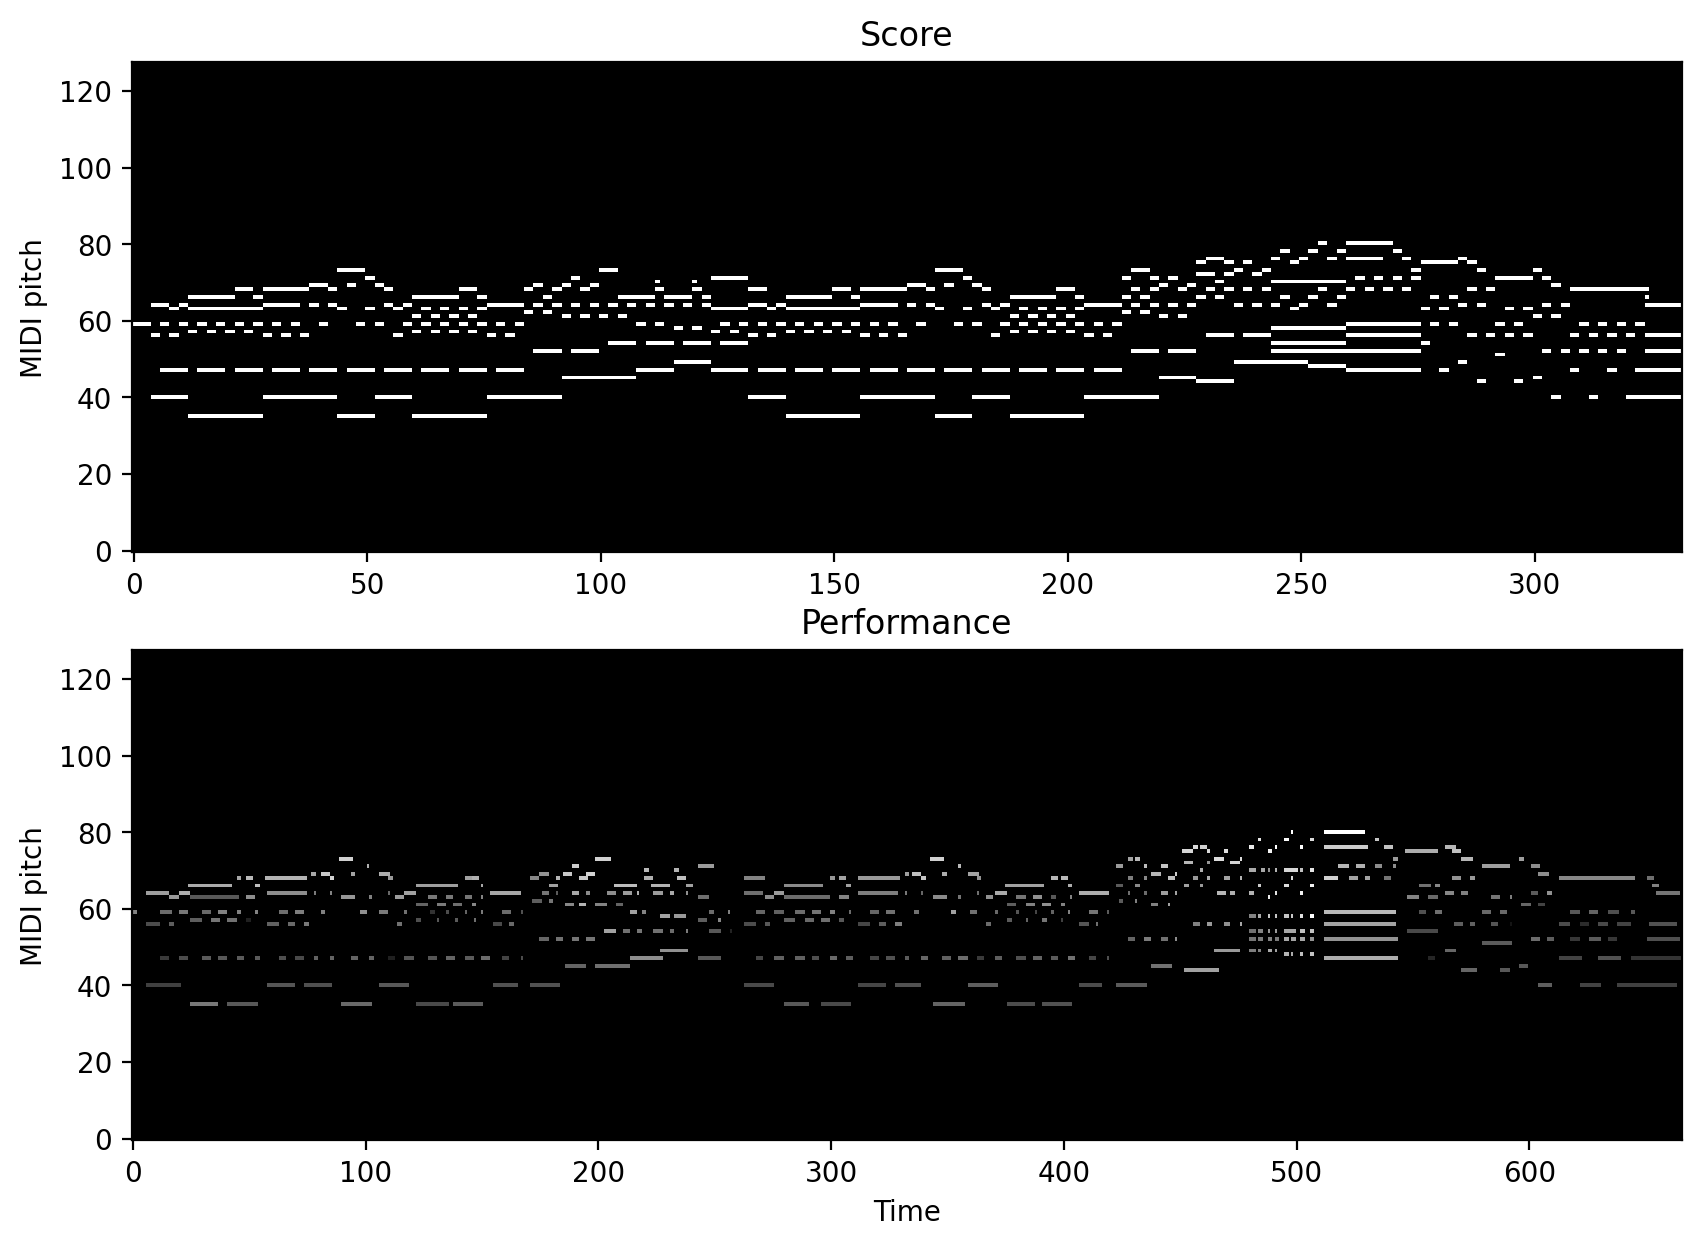

In [12]:
%matplotlib inline

fig, axes = plt.subplots(2, figsize=(10, 7))
axes[0].imshow(
    score_pr.todense(), 
    aspect = "auto", 
    origin="lower", 
    cmap="gray",
    interpolation="nearest",
)
axes[1].imshow(
    performance_pr.todense(), 
    aspect = "auto", 
    origin="lower", 
    cmap="gray",
    interpolation="nearest",
)
y_label = "Piano key" if use_piano_range else "MIDI pitch"
axes[0].set_ylabel(y_label)
axes[1].set_ylabel(y_label)
axes[0].set_title("Score")
axes[1].set_title("Performance")
axes[1].set_xlabel("Time")
plt.show()

For more information, see the documentation of  [`compute_pianoroll`](https://partitura.readthedocs.io/en/latest/modules/partitura.utils.html#partitura.utils.compute_pianoroll).

### 2.2. Pitch Class Distributions

These features are the symbolic equivalent to *chroma* features in audio. This representation is basically a piano roll that has been folded into a single octave.

In [13]:
score_pc_pr = pt.utils.music.compute_pitch_class_pianoroll(
    score,
    normalize=True,
    time_unit="beat",
    time_div=4
)

Let's plot this feature and compare it to a piano roll of the same score!

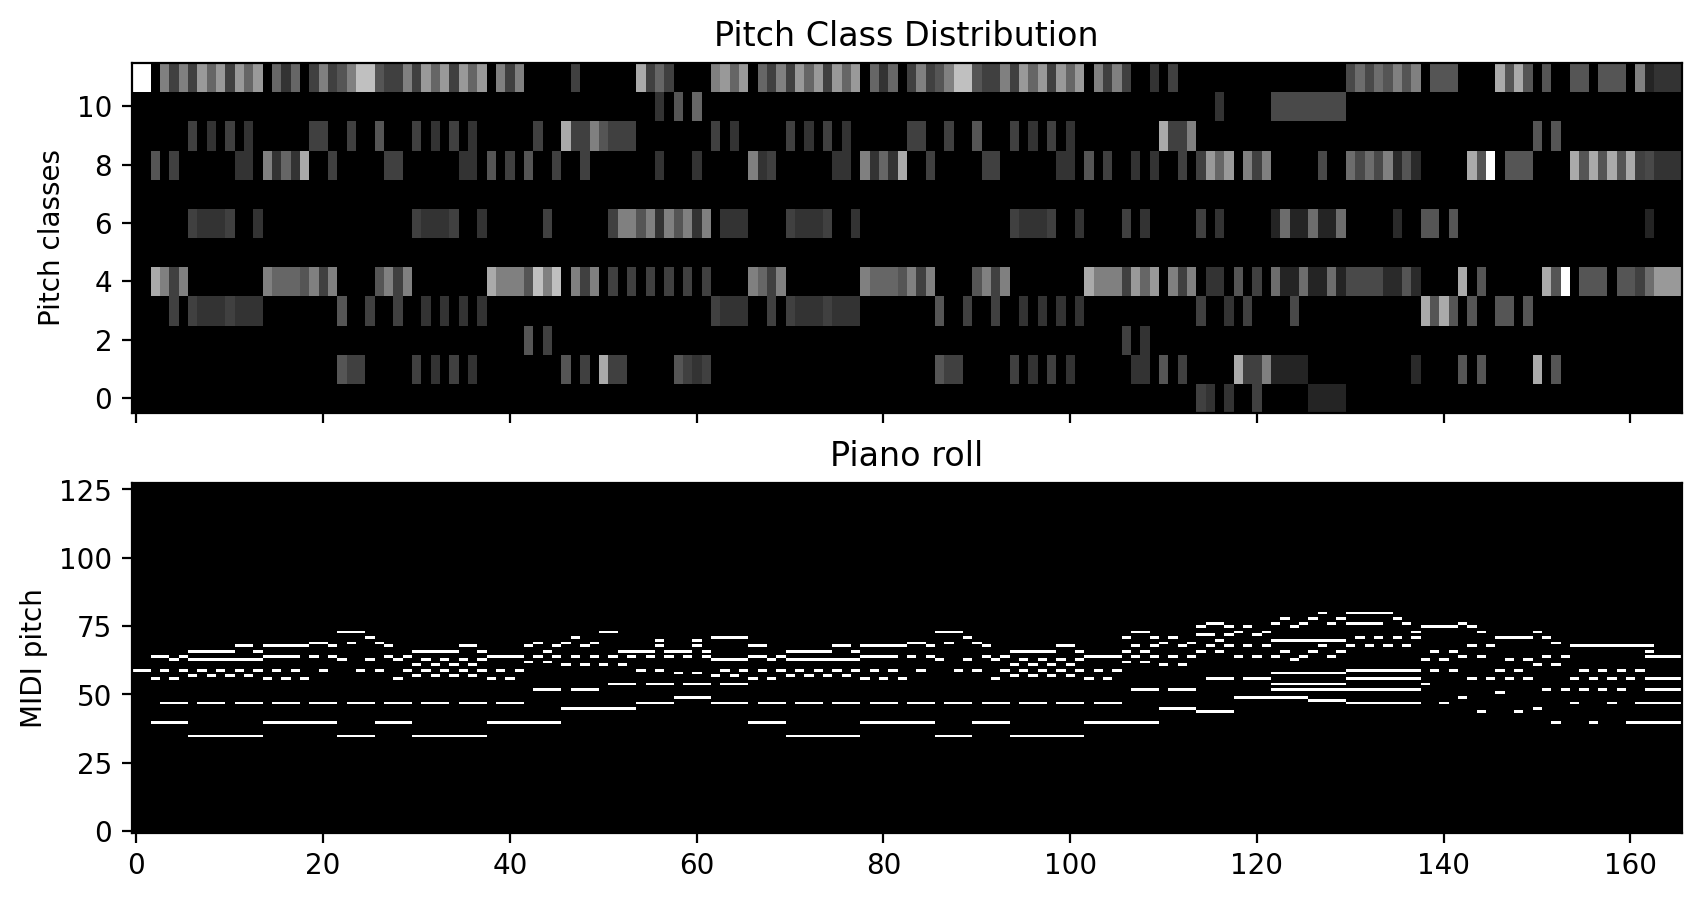

In [14]:
score_pr = pt.utils.music.compute_pianoroll(
    note_info=score,
    time_unit="beat",
    time_div=4,
    piano_range=False
)

fig, axes = plt.subplots(2, figsize=(10, 5), sharex=True)

axes[0].imshow(score_pc_pr, aspect = "auto", 
    origin="lower", 
    cmap="gray",
    interpolation="nearest",)
axes[0].set_title("Pitch Class Distribution")
axes[0].set_ylabel("Pitch classes")
axes[1].imshow(score_pr.todense(), 
               aspect="auto", 
               origin="lower", 
               cmap="gray", 
               interpolation="nearest")
axes[1].set_title("Piano roll")
axes[1].set_ylabel("MIDI pitch")

plt.show()

## 3. Alignment Methods

We move now to methods for computing the alignment between features from one version of a piece of music to another. Common methods are dynamic programming approaches like dynamic time warping (DTW) and probabilistic approaches like hidden Markov models.

### 3.1. Alignments with Dynamic Time Warping.

DTW is a dynamic programming algorithm to find the **optimal** alignment between to time-dependent sequences. In a nutshell, the DTW algorithm finds the alignment between two sequence in three steps:

1. Compute the pairwise distance between elements in sequence $\mathbf{X}$ and $\mathbf{Y}$.
2. Compute the accumulated cost matrix
3. Find the best alignment by backtracking 

We will explore these steps in detail. For now, let us generate some test data that we can play with!

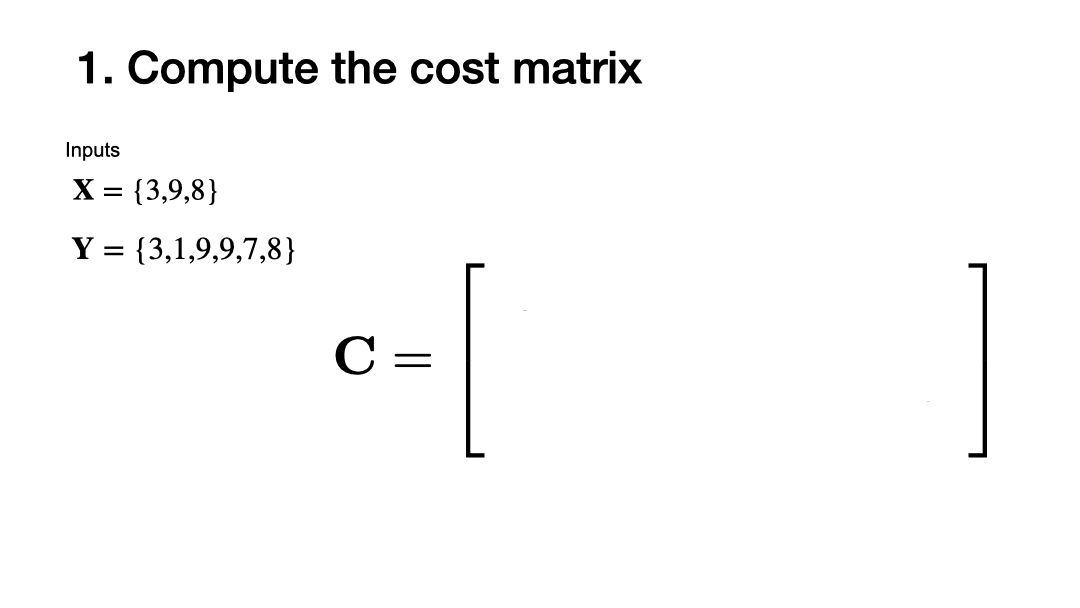

In [15]:
from slideshow_helper import show_slideshow_or_gif

show_slideshow_or_gif(interactive=False)

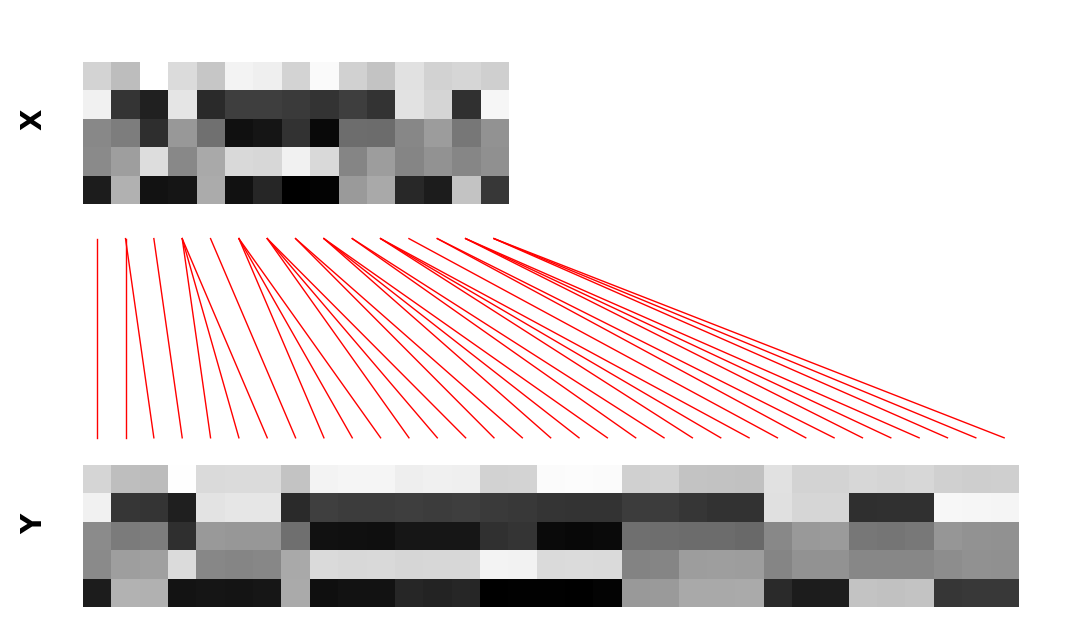

In [16]:
# This is a helper method to generate sample sequences 
# (see helper.py for documentation)

# lenght of the "reference" sequence
lenX = 15

# dimensionality of the feature space
K = 5

# This method generates an example sequence
X, Y, gr_path = generate_example_sequences(
    lenX=lenX, 
    centers=3, 
    n_features=K,
    maxreps=4, 
    minreps=1, 
    noise_scale=0.1
)

# Let us plot the data to see how it looks like!
plot_alignment(X, Y, gr_path)

#### 3.1.1. Comparing the similarity of the features: Local cost distance

We would like to know how to compare the elements in $\mathbf{X}$ and $\mathbf{Y}$. For this we use a local distance function, which can be any distance(-like) function that is small when $\mathbf{x}_i$ is *similar* to $\mathbf{y}_j$.

Which distance to use depends on the problem at hand, although usual starting points are the Euclidean and the Manhattan ($L_1$) distances.

Using this local distance, we can compare the elements in both sequences by comparing the pairwise distance of all elements in $\mathbf{X}$ and $\mathbf{Y}$. This will result in a matrix $\mathbf{C}$, where the element $\mathbf{C}[i,j]$ is given by

$$\mathbf{C}[i,j] = \text{distance}(\mathbf{x}_i, \mathbf{y}_j)$$

Let's visualize the pairwise cost matrix. 

(See metrics implemented in [scipy.spatial.distance](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html))

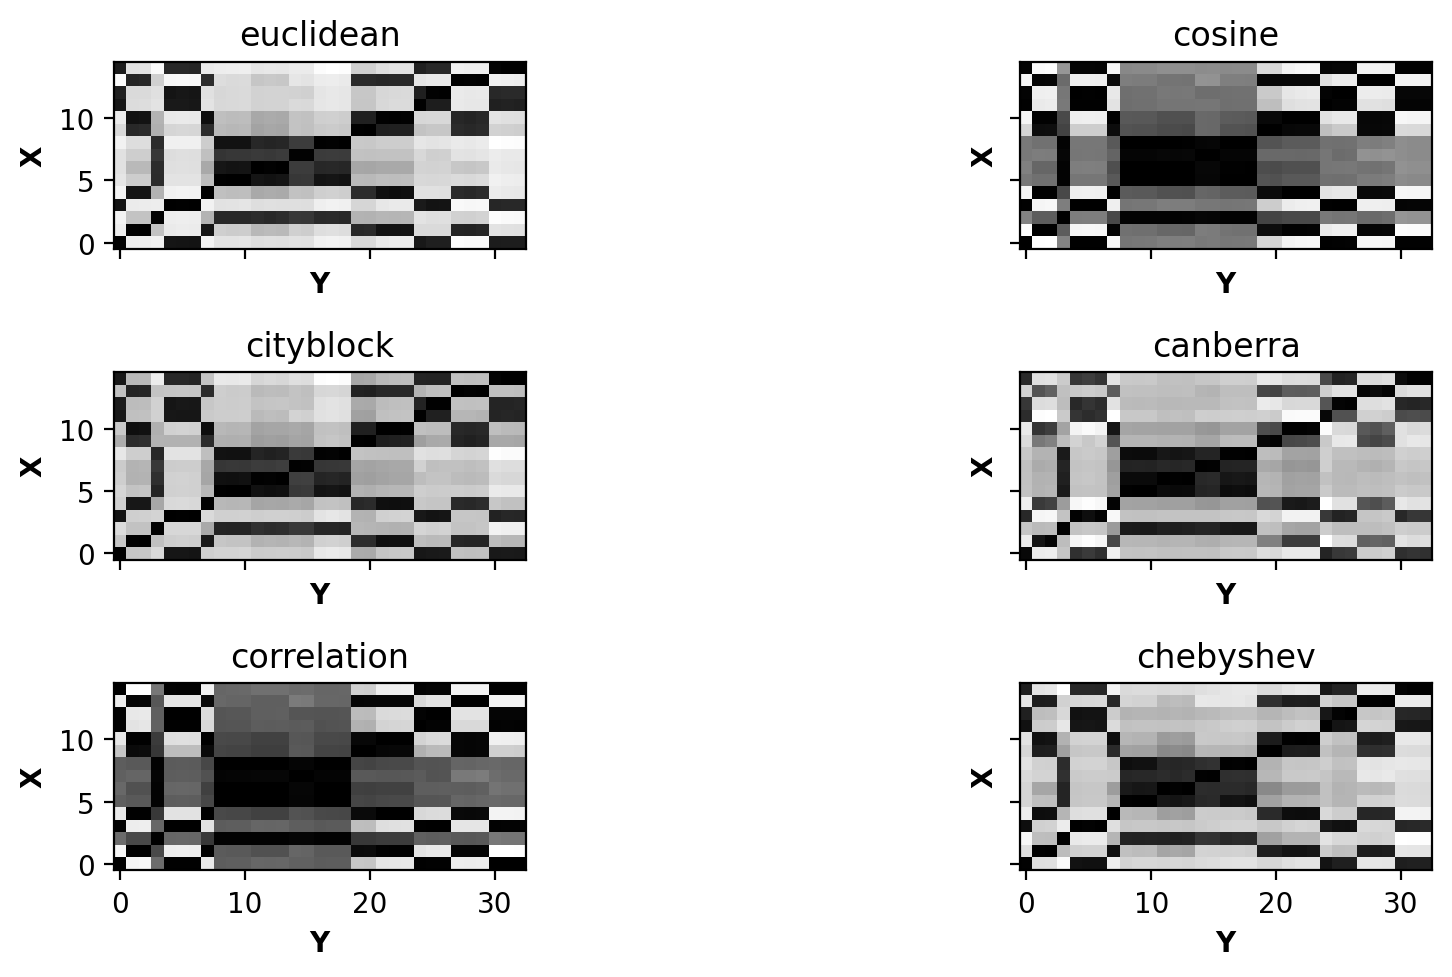

In [17]:
from alignment import pairwise_distance_matrix, accumulated_cost_matrix, optimal_warping_path
# Metrics to consider
# You can explore more possbilities in
# https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
metrics = [
    "euclidean", 
    "cosine", 
    "cityblock", 
    "canberra", 
    "correlation", 
    "chebyshev"
]

n_rows = int(np.ceil(np.sqrt(len(metrics))))
n_columns = int(np.ceil(len(metrics) / n_rows))
fig, axes = plt.subplots(n_rows, n_columns, 
                         sharex=True, sharey=True, 
                         figsize=(10, 5))

for i in range(n_rows):
    
    for j in range(n_columns):
        
        mix = i * n_columns + j
        
        if mix < len(metrics):
            # Compute pairwise distance matrix
            C = pairwise_distance_matrix(X, Y, metric=metrics[mix])
            # Plot matrix
            axes[i, j].imshow(C, origin='lower', aspect='equal', cmap='gray')
            axes[i, j].set_xlabel(r'$\mathbf{Y}$')
            axes[i, j].set_ylabel(r'$\mathbf{X}$')
            axes[i, j].set_title(metrics[mix])

plt.tight_layout()
plt.show()

#### 3.1.2. Computing the accumulated cost

* **Input**: Cost matrix $\mathbf{C}$ of size $N \times M$
* **Output**: $d_{DTW}$

**Procedure**

1. Initialize $N \times M$ matrix $D$ (accumulated cost) by

$$\mathbf{D}[n, 0] = \sum_{k=0}^{n} \mathbf{C}[k, 0]$$

for $n \in [0,N-1]$, and

$$\mathbf{D}[0, m] = \sum_{k=0}^{m} \mathbf{C}[0, k]$$

for $n \in [0, M-1]$

2. Compute in a nested loop for $n=1,\dots, N-1$ and $m=1, \dots, M-1$

$$\mathbf{D}[n, m] = \mathbf{C}[n, m] + \min \left\{\mathbf{D}[n-1, m-1], \mathbf{D}[n-1, m], \mathbf{D}[n, m-1] \right\}$$

3. The dynamic time warping distance is given by

$$d_{DTW}(\mathbf{X}, \mathbf{Y}) = \mathbf{D}[N-1, M-1]$$

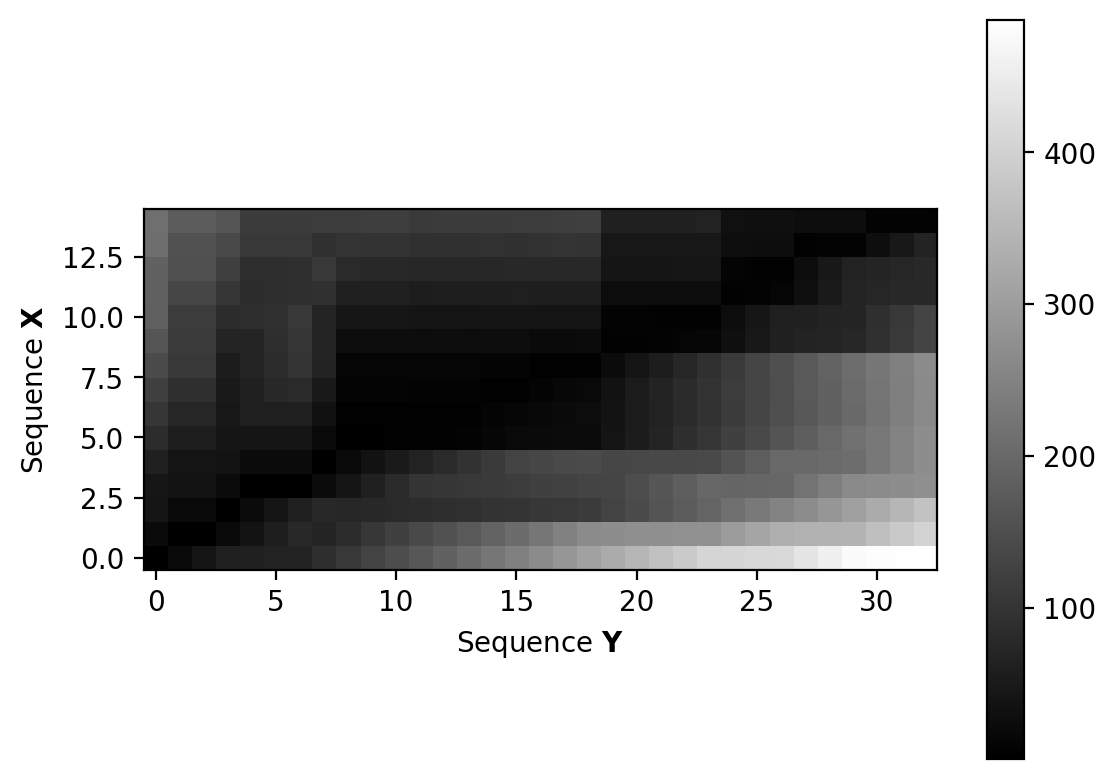

In [18]:
C = pairwise_distance_matrix(X, Y, metric='euclidean')
D = accumulated_cost_matrix(C) 

# Visualize accumulated cost matrix
plt.imshow(D, origin='lower', aspect='equal', cmap='gray')
plt.xlabel(r'Sequence $\mathbf{Y}$')
plt.ylabel(r'Sequence $\mathbf{X}$')
plt.colorbar()
plt.show()

#### 3.1.3. Compute Optimal Path

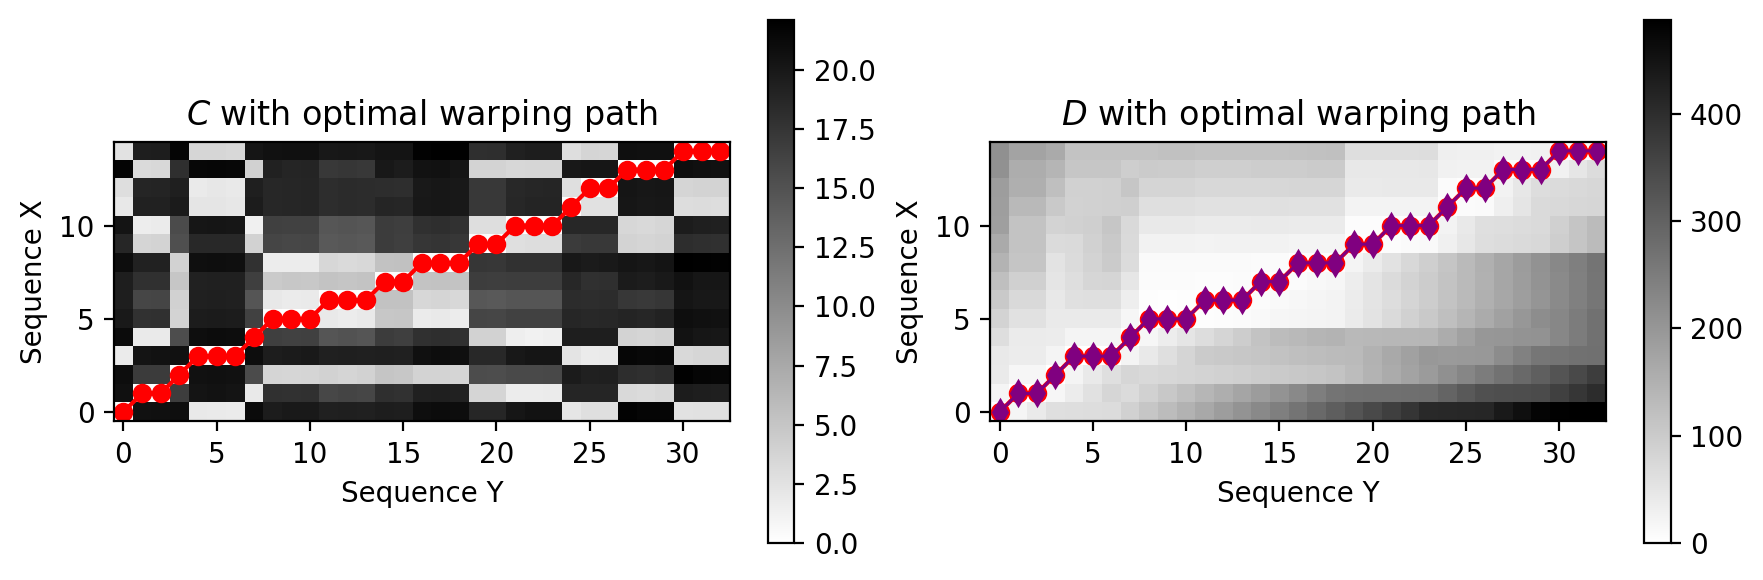

In [19]:
P = optimal_warping_path(D)

plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(C, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='r')
plt.clim([0, np.max(C)])
plt.colorbar()
plt.title('$C$ with optimal warping path')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.subplot(1, 2, 2)
plt.imshow(D, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='r')
plt.plot(gr_path[:, 1], gr_path[:, 0], marker='d', color='purple', linewidth=1.1)
plt.clim([0, np.max(D)])
plt.colorbar()
plt.title('$D$ with optimal warping path')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.tight_layout()


This naive implementation is very slow! You can only use it for aligning small sequences. For practical stuff, we are going to use the `fasdtw` package. This package contains an efficient implementation of vanilla DTW, as well as a faster approximation, called FastDTW.

In [20]:
from alignment import dynamic_time_warping, fast_dynamic_time_warping
import time

for lenX in [10, 100, 1000]:
    X, Y, gr_path = generate_example_sequences(
        lenX=lenX, 
        centers=3, 
        n_features=K,
        maxreps=2, 
        minreps=2, 
        noise_scale=0.1
    )
    st = time.process_time()
    path_naive, dtwd_naive = dynamic_time_warping(X, Y, return_distance=True)
    et_naive = time.process_time() - st

    st = time.process_time()
    path_fdtw, dtwd_fdtw = fast_dynamic_time_warping(X, Y, return_distance=True)
    et_fdtw = time.process_time() - st

    print(f"Input sizes: X:{X.shape} Y:{Y.shape}")
    print(f"\tDTW: {dtwd_naive:.3f} ({et_naive * 1000:.2f} ms)") 
    print(f"\tFastDTW: {dtwd_fdtw:.3f} ({et_fdtw * 1000:.2f} ms)")

Input sizes: X:(10, 5) Y:(20, 5)
	DTW: 3.725 (0.00 ms)
	FastDTW: 3.725 (0.00 ms)
Input sizes: X:(100, 5) Y:(200, 5)
	DTW: 43.119 (0.00 ms)
	FastDTW: 43.119 (46.88 ms)
Input sizes: X:(1000, 5) Y:(2000, 5)
	DTW: 427.196 (1390.62 ms)
	FastDTW: 427.196 (140.62 ms)


#### 3.1.4. Creating note-level alignments from sequential alignment information

Dynamic Time Warping and related sequence alignment algorithms return a path between two sequences or time series. Note alignment of two polyphonic parts is categorically different from a time series alignment. To get to a note alignment, we need to figure out what notes are played at a specific time in the piano roll. Sometimes this information might be imprecise so we need to relax the search for notes at some piano roll time to find all relevant notes.

In [21]:
score_pr, sidx = pt.utils.music.compute_pianoroll(
    note_info=score,
    time_unit="beat",
    time_div=8,
    return_idxs=True,
    piano_range=True,
    binary=True,
    note_separation=True,
)

performance_pr, pidx = pt.utils.music.compute_pianoroll(
    note_info=performance,
    time_unit="sec",
    time_div=10,
    return_idxs=True,
    piano_range=True,
    binary=True,
    note_separation=True,
)

reference_features = score_pr.todense().T
performance_features = performance_pr.todense().T

In [22]:
# pitch_index, onset, offset, midi_pitch
sidx[:5]

array([[38,  0,  3, 59],
       [19,  4, 11, 40],
       [19,  4,  5, 40],
       [35,  4,  5, 56],
       [43,  4,  7, 64]])

In [23]:
# idx correspond to notes in note_array
snote_array = score.note_array()
print(snote_array[:5])

# Check that the pitch in the note array corresponds to
# the fourth column in the indices from the note array
assert(all(snote_array["pitch"] == sidx[:, 3]))

[(-0.5, 0.5 , -0.5, 0.5 , 0,  8, 59, 1, 'n1', 16)
 ( 0. , 1.  ,  0. , 1.  , 8, 16, 40, 7, 'n4', 16)
 ( 0. , 0.25,  0. , 0.25, 8,  4, 40, 4, 'n4voice_overlap', 16)
 ( 0. , 0.25,  0. , 0.25, 8,  4, 56, 3, 'n3', 16)
 ( 0. , 0.5 ,  0. , 0.5 , 8,  8, 64, 1, 'n2', 16)]


In [24]:
# Dynamic time warping
dtw_alignment = fast_dynamic_time_warping(
    X=reference_features, 
    Y=performance_features, 
    metric="cityblock",
)

ValueError: Input vector should be 1-D.

In [ ]:
note_alignment = greedy_note_alignment(
    warping_path=dtw_alignment, 
    idx1=sidx, 
    note_array1=score.note_array(), 
    idx2=pidx, 
    note_array2=performance.note_array()
)

In [ ]:
note_alignment[:5]

## 2.4. Comparing alignments

Let's compare different alignment methods

In [ ]:
# This file contains the ground truth alignment
# gt_alignment_fn = "content/mozart_k265_var1.match"

# This file contains the ground truth alignment
gt_alignment_fn = os.path.join(MATCH_DIR, "Chopin_op10_no3_p01.match")

# Load the alignment and the performance
performance, gt_alignment = pt.load_match(
    gt_alignment_fn, 
    pedal_threshold=127, 
    first_note_at_zero=True
)
pnote_array = performance.note_array()

# Load the score
score_fn = os.path.join(MUSICXML_DIR, "Chopin_op10_no3.musicxml")
score = pt.load_score(score_fn)
snote_array = score.note_array()

In [ ]:
# Compute the features
score_pcr, sidx = pt.utils.music.compute_pitch_class_pianoroll(
    note_info=score,
    time_unit="beat",
    time_div=8,
    return_idxs=True,
    binary=True,
    note_separation=True,
)

performance_pcr, pidx = pt.utils.music.compute_pitch_class_pianoroll(
    note_info=performance,
    time_unit="sec",
    time_div=8,
    return_idxs=True,
    binary=True,
    note_separation=True,
)

reference_features = score_pcr.T
performance_features = performance_pcr.T

In [ ]:
# DTW
dtw_pcr_warping_path = fast_dynamic_time_warping(
    X=reference_features, 
    Y=performance_features, 
    metric="cityblock",
)

dtw_pcr_alignment = greedy_note_alignment(
    warping_path=dtw_pcr_warping_path, 
    idx1=sidx, 
    note_array1=snote_array, 
    idx2=pidx, 
    note_array2=pnote_array,
)

In [ ]:
# Compute the features
score_pr, sidx = pt.utils.music.compute_pianoroll(
    note_info=score,
    time_unit="beat",
    time_div=8,
    return_idxs=True,
    piano_range=True,
    binary=True,
    note_separation=True,
)

performance_pr, pidx = pt.utils.music.compute_pianoroll(
    note_info=performance,
    time_unit="sec",
    time_div=8,
    return_idxs=True,
    piano_range=True,
    binary=True,
    note_separation=True,
)

reference_features = score_pr.toarray().T
performance_features = performance_pr.toarray().T

# DTW
dtw_pr_warping_path = fast_dynamic_time_warping(
    X=reference_features, 
    Y=performance_features, 
    metric="cityblock",
)

dtw_pr_alignment = greedy_note_alignment(
    warping_path=dtw_pr_warping_path, 
    idx1=sidx, 
    note_array1=snote_array, 
    idx2=pidx, 
    note_array2=pnote_array,
)

In [ ]:
# invent a linear alignment for testing
from helper import dummy_linear_alignment

# Dummy linear alignment
linear_warping_path = dummy_linear_alignment(
    X=reference_features, 
    Y=performance_features,
)

linear_alignment = greedy_note_alignment(
    warping_path=linear_warping_path, 
    idx1=sidx, 
    note_array1=snote_array, 
    idx2=pidx, 
    note_array2=pnote_array,
)

In [ ]:
plt.plot(linear_warping_path[:, 0], linear_warping_path[:, 1], label="linear")
plt.plot(dtw_pr_warping_path[:, 0], dtw_pr_warping_path[:, 1], label="DTW (piano roll)")
plt.plot(dtw_pcr_warping_path[:, 0], dtw_pcr_warping_path[:, 1], label="DTW (pitch class)")
plt.legend()
plt.xlabel('Index in score')
plt.ylabel('Index in performance')
plt.show()

To inspect an alignment, we can use [**Parangonada**](https://sildater.github.io/parangonada/), a tool to compare alignments developed at our institute!

In [ ]:
# Export files to Parangonada
outdir = "parangonada_files"
if not os.path.exists(outdir):
    os.mkdir(outdir)
pt.save_parangonada_csv(
    alignment=dtw_pr_alignment,
    performance_data=performance,
    score_data=score,
    zalign=linear_alignment,
    outdir="parangonada_files",
)

In [ ]:
from helper import evaluate_alignment_notewise

print(f"Method\tF-score\tPrecision\tRecall")
method = "linear"

methods = [
    (linear_alignment, "linear"),
    (dtw_pr_alignment, "DTW (piano roll)"),
    (dtw_pcr_alignment, "DTW (pitch class)"),
]

for align, method in methods:
    precision, recall, fscore = evaluate_alignment_notewise(
        prediction=align,
        ground_truth=gt_alignment
    )
    print(f"{method}\t{fscore:.4f}\t{precision:.4f}\t{recall:.4f}")

## 2.5. Alignment Applications

In this example, we are going to compare tempo curves of different performances of the same piece. Partitura includes a utility function called `get_time_maps_from_alignment`which creates functions (instances of [`scipy.interpolate.interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)) that map score time to performance time (and the other way around).

In [ ]:
# get all match files
piece = "Chopin_op10_no3"
matchfiles = glob.glob(os.path.join(MATCH_DIR, f"{piece}_p*.match"))
matchfiles.sort()

# Load the score
score_fn = os.path.join(MUSICXML_DIR, f"{piece}.musicxml")
score = pt.load_score(score_fn)
score_part = score[0]
snote_array = score.note_array()

# Score time from the first to the last onset
score_time = np.linspace(snote_array['onset_beat'].min(),
                         snote_array['onset_beat'].max(),
                         100)
# Include the last offset
score_time_ending = np.r_[
    score_time, 
    (snote_array['onset_beat'] + snote_array['duration_beat']).max() # last offset
]

tempo_curves = np.zeros((len(matchfiles), len(score_time)))
for i, matchfile in enumerate(matchfiles):
    # load alignment
    perf, alignment = pt.load_match(matchfile)
    # Get score time to performance time map
    _, stime_to_ptime_map = pt.utils.music.get_time_maps_from_alignment(
        perf, score, alignment)
    # Compute naïve tempo curve
    performance_time = stime_to_ptime_map(score_time_ending)
    tempo_curves[i,:] = 60 * np.diff(score_time_ending) / np.diff(performance_time)

In [ ]:
fig, ax = plt.subplots(1, figsize=(15, 8))
color = plt.cm.rainbow(np.linspace(0, 1, len(tempo_curves)))
for i, tempo_curve in enumerate(tempo_curves):
    ax.plot(score_time, tempo_curve, 
            label=f'pianist {i + 1:02d}', alpha=0.4, c=color[i])

# plot average performance
ax.plot(score_time, tempo_curves.mean(0), label='average', c='black', linewidth=2)

# get starting time of each measure in the score
measure_times = score_part.beat_map([measure.start.t for measure in score_part.iter_all(pt.score.Measure)])
# do not include pickup measure
measure_times = measure_times[measure_times >= 0]
ax.set_title(piece)
ax.set_xlabel('Score time (beats)')
ax.set_ylabel('Tempo (bpm)')
ax.set_xticks(measure_times)
plt.legend(frameon=False, bbox_to_anchor = (1.15, .9))
plt.grid(axis='x')
plt.show()

## Conclusion

In this tutorial we learned how to deal how to load, compute, process, and save alignments with partitura.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CPJKU/partitura_tutorial/blob/main/notebooks/02_alignment/Symbolic_Music_Alignment.ipynb)

